# Multivariate Statistik und Machine Learning: Assignment 5

In this exercise we will use unsupervised methods for clustering, in this case instead of having $X$ and $Y$ pairs at train time, we *only* have the input data $X$ at train time.

We will work with 3 popular methods: K-means, Spectral Clustering and Mean-shift.

To get familiar with their adavantages and disanvantages we will use the 3 methods with 3 different datasets:

- spiral
- blobs
- hand-written digits

## Ex 1 -- Spectral Clustering (3 points)

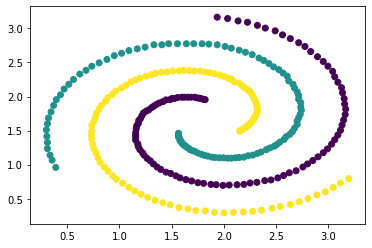

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import SpectralClustering

data = np.load("spiral.npz")
x = data["x"]
y = data["y"]

plt.scatter(x[:,0],x[:,1],c=y)

### 1.1. Adjacency matrix
implement the function 'build_adjacency_matrix' which receives as input the array $x$ and creates and adjacency matrix using the RBF kernel:
$$a_{ij} = e^{(-\gamma \cdot d(x_i,x_j)^2)}$$
where $d(\cdot,\cdot))$ represents the euclidian distance.

hint: try to use the numpy array operations and avoid for loops to speed up the code

In [3]:
from scipy.spatial.distance import cdist
def build_adjacency_matrix(x,gamma):
    """
        x: numpy array shape = [N samples, input dimension]
        gamma: parameter for the RBF kernel
    
        return the adjacency matrix A (shape =  [N samples,N samples])
    """
    
    restructed_x = x.reshape(x.shape[0],1,x.shape[1])
    oo = restructed_x.repeat(x.shape[0],axis = 1) # set up N x N matrix for each dimension
    dist = np.linalg.norm(oo-np.swapaxes(oo,0,1), axis= 2) # pairwise differences with help of the transpose and norm along dimensions
    #cdis = cdist(x, x, 'euclidean') ## Function from the scipy documentation (for validation)
    #print(np.max(cdis-dist),np.min(cdis-dist)) # maximal/minimal error
    
    
    A= np.exp(-1*gamma*dist**2)
    
    return A
    

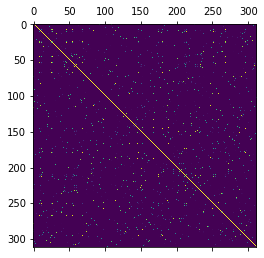

In [4]:
A = build_adjacency_matrix(x,gamma=100)
# visualize matrix A
plt.matshow(A)

### 1.2. sklearn spectral clustering

validate your adjacency matrix using the spectral clustering framework of sklearn. choose as affinity parameter the option 'precomputed'. What is a good value for $\gamma$ ?

#### a good value for gamma : 100

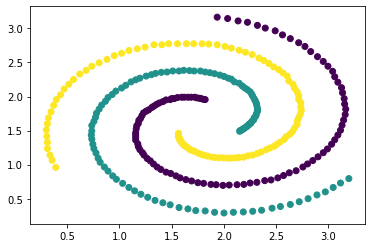

In [5]:
sc = SpectralClustering(n_clusters=3 ,affinity='precomputed')
y_pred = sc.fit_predict(A)
plt.scatter(x[:,0],x[:,1],c=y_pred)
#### a good value for gamma : 100

### 1.3. Affinity options
Try now to use as affinity option 'nearest_neighbors' which builds a graph using the input data. What is a good value for 'n_neighbors' in this case?

#### good value for n_neighbors: 4

C:\Users\Ketzel\anaconda3\lib\site-packages\sklearn\manifold\_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


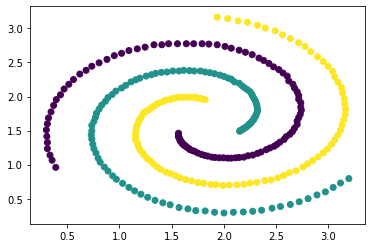

In [6]:
sc = SpectralClustering(n_clusters=3 ,n_neighbors = 4,affinity='nearest_neighbors')
y_pred = sc.fit_predict(x) 
plt.scatter(x[:,0],x[:,1],c=y_pred) 

## Ex 2 -- K-means (2 point)


In [7]:
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA


### 2.1. Blobs dataset

Using the KMeans class, cluster the points in the blobs dataset. You may explore the different configurations such as initalization (random or k-means++), n_init.

Choosing the number of n_clusters without extra information is not trivial. For blobs, we don't have any labels. Which configurations are be thest for this dataset? How many n_custers would you choose?

#### n_cluster = 6 seems to be a good option and configuration 'k-means++'

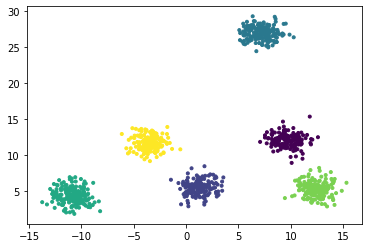

In [8]:
x = np.genfromtxt('blobs.csv', delimiter=',')
model = KMeans(n_clusters=6,init='k-means++')

y_hat = model.fit_predict(x)

plt.scatter(x[:,0],x[:,1],c=y_hat, marker='.')


### 2.2. Spiral dataset

Try to use the KMeans to cluster the Spiral dataset. 

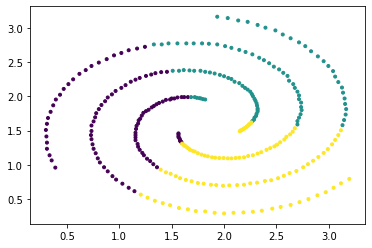

In [9]:
x = np.load("spiral.npz")['x']

model = KMeans(n_clusters=3,init='k-means++')

y_hat = model.fit_predict(x)

plt.scatter(x[:,0],x[:,1],c=y_hat, marker='.')

Does it work? Please explain your answer, which assumptions required for kmeans? would feature augmentation (as we did in regression) help here? Just explain what you would do, you are not required to implement anything. 

### No, it doesnt work
### Yes, you could try feature engineering. Because of the character of the spiral I would suggest to transform the data points in the following way:
### 1. center the data points by substract the over-all mean of all data points
### 2. augment the datapoints by transforming into the polar coordinates system  (x1,x2) --> (rho,phi(rho)) in which phi is depending on rho, so that the angle phi gets larger the larger the distance from the center rho
### 3. Rotate the (rho,phi)-points with a Givens-rotation matrix, so that the lines are approx. parallel to one main axis (for e.g. phi)
### 3. scale the rotated points down by a large factor --> you should get linear separable clusters along the main axis phi/rho which shouldn't be a problem for the algorithm anymore

### Ex 3 -- Mean Shift Clustering (3 points)

Complete the function ``ml_meanshift`` that performs the mean shift algorithm. The function takes 3 arguments:
 
* input data: sample points in a N-by-2 matrix (number of rows is the number of samples, dimensionality of the input data will always be 2 for this exercise)
* the kernel bandwidth $h$
* the stopping threshold $\vartheta$


It should return two values.
* cluster indexes: a column vector with N rows, specifying the cluster index for each sample
* cluster modes: a M-by-2 matrix, returning the cluster modes (the points with the highest density) for each cluster (where M is the number of clusters)
    
For this task, use the Epanechnikov kernel. Luckily all terms before the sum cancel out in the mean shift formula, leading to

$$\mathbf{q}_{t+1} = \frac{
            \sum_{i=1}^N \mathbf{x}_i 
            \max\left(0, 1 - \frac{\|\mathbf{q}_t - \mathbf{x}_i\|^2}{h^2} \right)
        } {
            \sum_{i=1}^N 
            \max\left(0, 1 - \frac{\|\mathbf{q}_t - \mathbf{x}_i\|^2}{h^2} \right)
        }$$

    
Start the mean shift procedure at each point and iterate until $\|\mathbf{q}_{t}-\mathbf{q}_{t-1}\| < \vartheta$ where $\vartheta$ is the threshold passed to the function. Additionally also count the iterations and add it as condtion so the loop does not run infinitely. You can use $200$ as the maximum value of iteration.

When the iteration stopped, decide if a cluster mode already exists that is closer than $\frac{h}{5}$. If yes, assign the point that you started at to this cluster. Otherwise, create a new cluster and assign the point to the new cluster.


In [10]:
# Some imports you need for the exercises
import numpy as np 
import matplotlib.pyplot as plt    
%matplotlib inline

import math
from numpy import linalg as la
import numpy.matlib

In [11]:
 # DO NOT MODIFY
def visualize_kmeans(data,idx,centers,updated=None):
    fig = plt.figure(figsize=(12,8))
    ax = fig.add_subplot(1,1,1)
    ax.scatter(data[:,0],data[:,1],marker='.', c=idx)
    ax.plot(centers[:,0],centers[:,1],'+',color='r',markersize=15,mew=2)
    plt.show()
def test_meanshift():
    data = np.genfromtxt('blobs.csv', delimiter=',')
    idx, centers = ml_meanshift(data,4,0.001)
    
    centers_2 = np.array(centers)

    
    visualize_kmeans(data=data,idx=idx,centers=centers_2)

In [12]:
def epa_kernel(data,q, h):
    dist = 1-(la.norm(q-data,axis = 1)/h)**2
    dist[dist < 0] = 0
    return dist

In [13]:
def ml_meanshift(data,h,theta):
    # ml_meanshift returns cluster indices and modes from computed with meanshift algorithm
    
    # initialization
    # modes
    cluster_modes = np.array([])
    ind = [1]
    #initialize index variable for data points
    cluster_index = np.ones(data.shape[0])
    
    ndim = data.shape[1]
    #s = number of data points
    s = data.shape[0]

    for i in range(s):
        
        #initialize starting q0 and q1 condition
        point = data[i,:]
        q0 = point
        dist = epa_kernel(data, q0, h)
        q1 = np.sum(data * dist.reshape(-1,1), axis = 0)/np.sum(dist)

        #iteration initilization
        it = 0
        #iterate until ||q_t - q_t-1|| < theta and it<200
        while la.norm(q0-q1) > theta and it < 200:
            #update break criterion values
            #compute q_t+1
            q0 = q1
            dist = epa_kernel(data, q0, h)
            q1 = np.sum(data * dist.reshape(-1,1), axis = 0)/np.sum(dist)
            #update iteration
            it = it+1
        
        
        #check for clusters in the vicinity
        #1st condition: if mode is not empty
        #2nd: if a cluster mode exists closer than h/5
        #else create a new cluster
        if cluster_modes.size != 0: # a lambda expression might be better in this case
           
            if  np.any(la.norm(cluster_modes-q1.reshape(1,ndim), axis = 1) < h/5):
                
                dist = la.norm(cluster_modes - point.reshape(1,ndim), axis = 1)
                cluster_index[i] = np.argmin(dist)
            else: 
                cluster_modes = np.vstack((cluster_modes,q1))
                cluster_index[i] = cluster_modes.shape[0]-1
        else:
            cluster_modes = np.hstack((cluster_modes,q1))
            cluster_index[i] = cluster_modes.shape[0]-1

    return cluster_index, cluster_modes
    

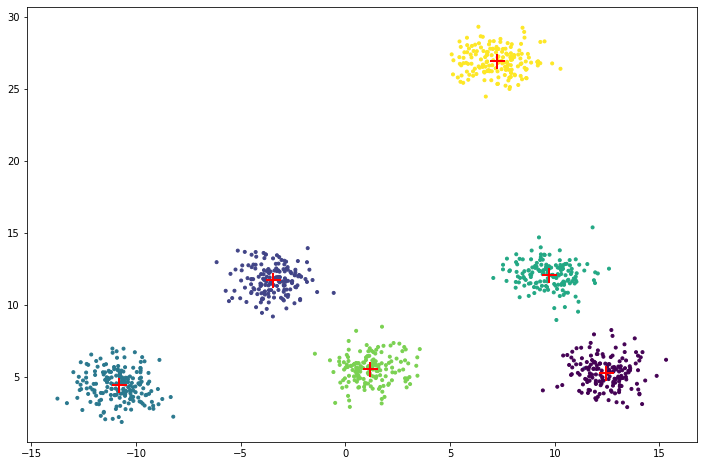

In [14]:
 test_meanshift()

### Ex 4 -- Handwritten digits (2 points)

Now we will wokrk with hand-written digits images that can be clustered. Let's first load the dataset and see some samples.

In [21]:
from sklearn.preprocessing import StandardScaler
from string import ascii_uppercase
x, y = load_digits(return_X_y=True)

scaler = StandardScaler()
scaler.fit(x)

x = scaler.transform(x)

In [22]:
def plot_digits(x,y=None, max_n = 8, random=True):
    x = scaler.inverse_transform(x)
    if random:
        samples = np.random.choice(x.shape[0], max_n,replace=False)
    else:
        samples = range(max_n)
    for i, index in enumerate(samples):
        
        plt.subplot(2, max_n//2, i + 1)
        plt.axis('off')
        plt.imshow(x[index].reshape(8,8), cmap=plt.cm.gray_r, interpolation='nearest')
        if y is not None:
            plt.title(f'cluster {ascii_uppercase[y[index]]}')
        

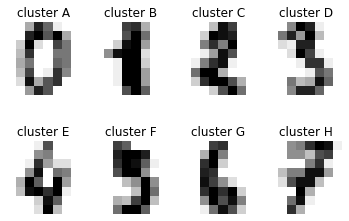

In [23]:
plot_digits(x, y, random=False)

Note here that we name the clusters A - H, in the reference data cluster A corresponds to digit 0, B to digit 1 and so on. But in a prediction using any method will just create clusters with out necesarrily matching the original correspondance.

Visualizing the complete dataset of images is challenging, for such purpose we will use T-SNE to visualize on a 2-dim plot. Each point in the plot represents one image, and different colors show the digit class.

[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 1797 samples in 0.046s...
[t-SNE] Computed neighbors for 1797 samples in 0.516s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1797
[t-SNE] Computed conditional probabilities for sample 1797 / 1797
[t-SNE] Mean sigma: 2.161185
[t-SNE] KL divergence after 250 iterations with early exaggeration: 66.624596
[t-SNE] KL divergence after 300 iterations: 1.256962


Text(0.5, 1.0, '2-dim visualization of the digits datasets')

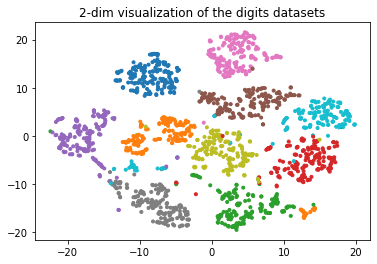

In [24]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, verbose=1, perplexity=20, n_iter=300,random_state=1)
tsne_results = tsne.fit_transform(x)
plt.scatter(tsne_results[:,0], tsne_results[:,1], c=y, cmap='tab10', marker ='.')
plt.title('2-dim visualization of the digits datasets')

Using kmeans we can cluster the digits:

In [25]:
model = KMeans(n_clusters=10)

y_hat = model.fit_predict(x)

Text(0.5, 1.0, 'Kmeans default')

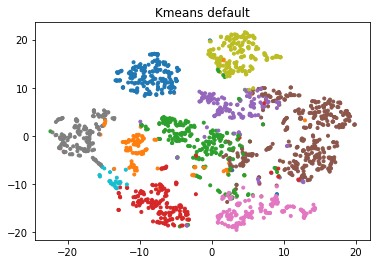

In [27]:
plt.scatter(tsne_results[:,0], tsne_results[:,1], c=y_hat, cmap='tab10', marker='.')
plt.title('Kmeans default')

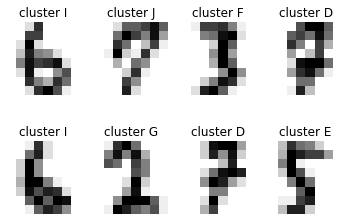

In [28]:
plot_digits(x, y_hat, max_n=8, random=True)

### 4.1. Clustering digits
Using KMeans, try to find the best configuration, which parameters you consider the most important and why?

since computing a quantitative number for performance is more difficult here, you can justify your analysis by commenting the results on the T-SNE visualizayion.

In [29]:
from sklearn.cluster import KMeans, MeanShift, SpectralClustering

model = KMeans(n_clusters=10, init='k-means++',n_jobs = 1, n_init=5, max_iter=300, copy_x=False, tol=0.00001, precompute_distances=False, algorithm='auto')
y_hat = model.fit_predict(x)

Text(0.5, 1.0, 'Kmeans improved')

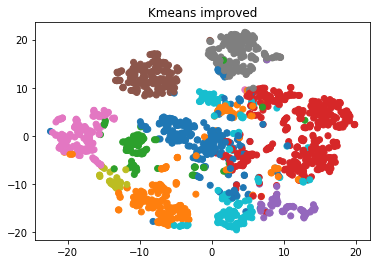

In [30]:
plt.scatter(tsne_results[:,0], tsne_results[:,1], c=y_hat, cmap='tab10')
plt.title('Kmeans improved')

Text(0.5, 1.0, '2-dim visualization of the digits datasets')

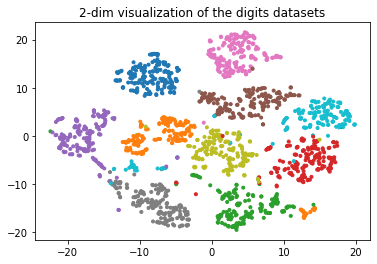

In [31]:
plt.scatter(tsne_results[:,0], tsne_results[:,1], c=y, cmap='tab10', marker ='.')
plt.title('2-dim visualization of the digits datasets')

#### Using KMeans, try to find the best configuration, which parameters you consider the most important and why?
#### Answer: - best and most important parameters: n_cluster = 10 (for obvious reasons), n_init = 20 (the results highly depend on the type of data and the starting points, so it's might be better to repeat it several times), algorithm = 'auto' (will choose between the better method between 'full' and 'elkan')

### 4.2. MeanShift and SpectralClustering
Try to use MeanShift and SpectralClustering for this dataset, for this exercise you may use the MeanShifi class from sklearn. Does it work? Which method would you prefer in the end KMeans, MeanShift or SpectralClustering? Justify your answwer.


In [38]:
model = MeanShift(bandwidth=5, cluster_all =False, bin_seeding= False)
# seeds=None, bin_seeding=False, min_bin_freq=1, cluster_all=True, n_jobs=None,, max_iter=300
y_hat = model.fit_predict(x)


Text(0.5, 1.0, 'Mean Shift default')

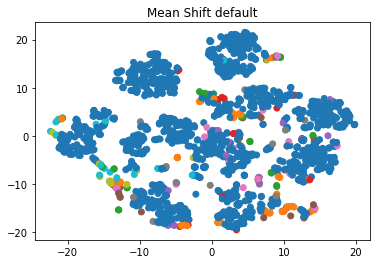

In [39]:
plt.scatter(tsne_results[:,0], tsne_results[:,1], c=y_hat, cmap='tab10')
plt.title('Mean Shift default')

In [40]:
model = SpectralClustering(n_clusters=10,n_init=5,n_neighbors= 5, gamma=10, affinity='nearest_neighbors')
#, n_neighbors=10, eigen_tol=0.0, assign_labels='kmeans', , coef0=1, kernel_params=None, n_jobs=None
y_hat = model.fit_predict(x)


Text(0.5, 1.0, 'Spectral Clustering')

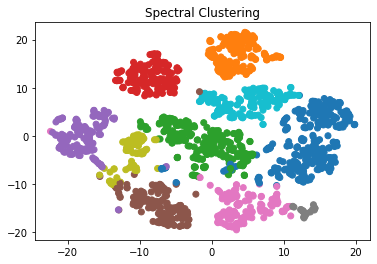

In [41]:
plt.scatter(tsne_results[:,0], tsne_results[:,1], c=y_hat, cmap='tab10')
plt.title('Spectral Clustering')

#### Answer: - MeanShift doesn't work in this case --> the distances between the cluster are too small
#### - SpectralClustering provides better results --> it works
#### - Choice: If I had to choose between these 3 methods, I would choose SpectralClustering because more the amount of clusters in which the points are 'right' determined is higher than in the other two. Therefore, the clusters are more separable because they have less outliers (compared to KMean) and you could easier separate the different clusters to each other in a further step. labeling these data would also mean to be less effort.